### follow the idea found in these articles
### doesn't use the number of satellites used
#### https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4046178/
#### https://pubs.rsc.org/en/content/articlelanding/2012/EM/c2em30190c#!divAbstract
#### The test dataset, due to technical difficulty, has a 7 hour differences, compared with activity diary

In [140]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import seaborn as sns
from sklearn.decomposition import PCA

## data was collected through the 'GPS tracker' App offered in iOS
#### Three sample days were collected by Lori and then processed using the following code
#### each day collected around 9 hrs of data

In [2]:
filename = ['Test_1.csv','Test_2.csv','Test_3.csv']
outputname = ['sep_26_manual.xlsx','sep_27_manual.xlsx','sep_28_manual.xlsx']

#### Additional idea: Indoor status was confirmed only when the used-NSAT was maintained for at least 3 min. 
#### Speed was utilized to further classify outdoor points into transit or walking. Walking status was finalized only when the speed was maintained for at least 3 min. 
### my approach: assign 0 to indoor, 1 to outdoor, 2 to in transit

In [3]:
"""
for j in range (len(filename)):
    GPS = pd.read_csv(filename[j],delimiter=';',header=0)
    # convert from UTC to US/Pacific timezone
    GPS['new_time'] = pd.to_datetime(GPS['timestamp']).dt.tz_convert('US/Pacific').dt.tz_localize(None)
    GPS.drop('timestamp',axis=1,inplace=True)
    GPS.drop_duplicates(inplace=True)
    GPS['dummy'] = 0 # solve the duplicated indices
    GPS = GPS.groupby('dummy').apply(lambda x : x.drop_duplicates('new_time')
                                          .set_index('new_time')
                                          .resample('10S') # resample to every 10s
                                          .ffill())
    GPS.drop('dummy',axis=1,inplace=True)
    GPS = GPS.iloc[1:,:] # drop first null column
    
    # manually assign label for different conditions
    GPS['manual_judgement'] = 0
    # using vertical/horizontal accuracy and speed to classify the condition
    for i in range(GPS.shape[0]):
        if GPS.iloc[i,5] <= 0:
            if GPS.iloc[i,3] >= 50: # would mis-classify when the user is near window ( would be like 30, or 10 ish)
                GPS.iloc[i,-1] = 0
            else:
                GPS.iloc[i,-1] = 1
        elif GPS.iloc[i,5] <=8: # normal walking speed is 3-6, running is 12-14
            if GPS.iloc[i,3] >= 50:
                GPS.iloc[i,-1] = 0
            else:
                GPS.iloc[i,-1] = 1

        else:
            GPS.iloc[i,-1] = 2 # would mis-classify when the bus stopped for traffic
            
    GPS.to_excel(outputname[j])"""

In [2]:
openmap_26 = pd.read_csv('sep_26.csv')
openmap_27 = pd.read_csv('sep_27.csv')

## Data was recorded through Andriod app GPS Logger on Oct 7

In [53]:
filename = ['GPS_logger_Oct_7.txt','GPS_logger_Oct_8.txt','GPS_logger_Oct_9.txt','GPS_logger_Oct_10.txt','GPS_logger_Oct_11.txt']
outputname = ['logger_oct_7.xlsx','logger_oct_8.xlsx','logger_oct_9.xlsx','logger_oct_10.xlsx','logger_oct_11.xlsx']
data_arr = []
clustering_arr = []

## Supervised
### Add new feature 'sat_ratio' to capture the useful info of satellites

In [3]:
for i in range(len(filename)):
    logger = pd.read_csv(filename[i],delimiter=',')
    logger.drop(['type','name','desc','bearing(deg)'],axis=1,inplace=True)
    logger['new_time'] = pd.to_datetime(logger['date time']).dt.tz_localize('UTC').dt.tz_convert('US/Pacific').dt.tz_localize(None)
    logger.drop('date time',axis=1,inplace=True)
    logger = logger.resample('1T',on='new_time').mean()
    logger['sat_ratio'] = (logger['sat_used'] / logger['sat_inview']) *1.0
    logger = logger.fillna(-1) # fill empty rows
    logger['classification'] = -1
    for j in range(logger.shape[0]):
        # generally, if the accuracy is low, sat_ratio is low then the participant is indoor
        if logger.iloc[j,8] >= 0.7:
            logger.iloc[j,-1] = 1 # if sat_ratio is higher than 0.7, it is definitely outside
        elif logger.iloc[j,8] < 0: 
            logger.iloc[j,-1] = 0 # the data is not available, it is definitely inside
        elif logger.iloc[j,2] >= 2.5 and logger.iloc[j,8] <= 0.7: 
            logger.iloc[j,-1] = 0 
        elif logger.iloc[j,2] < 2.5 and logger.iloc[j,8] < 0.7:
            # accuracy helps to correct the sat_ratio
            logger.iloc[j,-1] = 1
    #logger.to_excel(outputname[i])      
    data_arr.append(logger)
   

In [5]:
master_data = pd.concat([data_arr[0],data_arr[1],data_arr[2],data_arr[3],data_arr[4]],axis=0)

Text(0.5, 1.0, 'Oct7-Oct11')

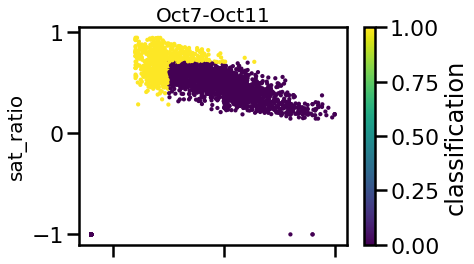

In [206]:
ax2 = master_data.plot.scatter(x='accuracy(m)', y='sat_ratio', c='classification', colormap='viridis',s=5)


Text(0.5, 1.0, 'Oct7-Oct11')

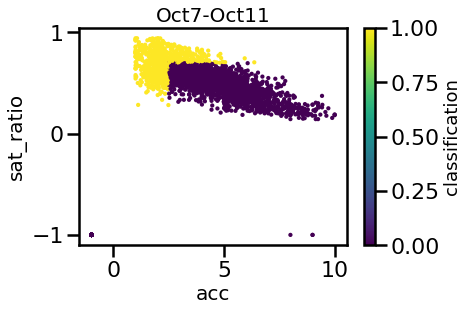

In [210]:
plt.scatter(x=master_data['accuracy(m)'],y=master_data['sat_ratio'],c=master_data['classification'],cmap='viridis',s=5)
plt.xlabel('acc',fontsize=20)
plt.ylabel('sat_ratio',fontsize=20)
plt.colorbar().ax.set_ylabel('classification', rotation=-270,fontsize=18)

plt.title('Oct7-Oct11',fontsize=20)

In [100]:
corr = logger.corr()
corr.style.background_gradient(cmap='coolwarm')

,latitude,longitude,accuracy(m),altitude(m),geoid_height(m),speed(m/s),sat_used,sat_inview,sat_ratio,classification
latitude,1,-1,0.822111,0.97036,-0.999994,0.260961,0.838543,0.987599,0.973695,0.269089
longitude,-1,1,-0.821984,-0.970361,0.999991,-0.261078,-0.838662,-0.98761,-0.973741,-0.269216
accuracy(m),0.822111,-0.821984,1,0.812778,-0.822812,0.0915001,0.433463,0.801506,0.694294,-0.185657
altitude(m),0.97036,-0.970361,0.812778,1,-0.970125,0.190021,0.811299,0.959445,0.943541,0.247954
geoid_height(m),-0.999994,0.999991,-0.822812,-0.970125,1,-0.260361,-0.837777,-0.98748,-0.973396,-0.268161
speed(m/s),0.260961,-0.261078,0.0915001,0.190021,-0.260361,1,0.415569,0.265029,0.337228,0.446897
sat_used,0.838543,-0.838662,0.433463,0.811299,-0.837777,0.415569,1,0.848994,0.936953,0.618528
sat_inview,0.987599,-0.98761,0.801506,0.959445,-0.98748,0.265029,0.848994,1,0.962167,0.292827
sat_ratio,0.973695,-0.973741,0.694294,0.943541,-0.973396,0.337228,0.936953,0.962167,1,0.422009
classification,0.269089,-0.269216,-0.185657,0.247954,-0.268161,0.446897,0.618528,0.292827,0.422009,1


In [9]:
X = master_data[['accuracy(m)','sat_ratio']]
y = master_data['classification']

### Another ploting method
#### https://towardsdatascience.com/visualizing-support-vector-machine-decision-boundary-69e7591dacea

In [33]:
def plot_contour(ax,clf,xx,yy, **params):
    Z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx,yy,Z,**params)
    return out 

In [34]:
def make_meshgrid(x,y,h=.2):
    x_min,x_max = x.min()-1,x.max()+1
    y_min,y_max = y.min()-1,y.max()+1
    xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
    return xx,yy

### SVM

In [37]:
clf = SVC(gamma='scale')
C_list = [{'kernel':['rbf'],'C':[0.001,0.01,0.1],'gamma':[0.05,0.2,1,5]}]
search = GridSearchCV(clf, C_list,cv=3)
search.fit(X,y)
print (search.best_params_)

{'C': 0.1, 'gamma': 5, 'kernel': 'rbf'}


In [40]:
clf=SVC(kernel=search.best_params_['kernel'],C=search.best_params_['C'],gamma=search.best_params_['gamma'])

In [41]:
classify=0
sc = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)
ave_acc_svm = []
ave_acc_svm_train = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    classify = clf.fit(X_train,y_train)
    ave_acc_svm_train.append(clf.score(X_train,y_train))
    ave_acc_svm.append(clf.score(X_test,y_test))


In [42]:
ave_acc_svm,ave_acc_svm_train

([0.9679389312977099,
  0.981679389312977,
  0.9358778625954198,
  0.981679389312977,
  0.9755725190839695],
 [0.9681335356600911,
  0.9726027397260274,
  0.9832402234636871,
  0.9763719512195121,
  0.9786520280573345])

In [43]:
#plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=5, cmap='autumn')
#plot_svc_decision_function(clf)

Text(0, 0.5, 'sat_ratio')

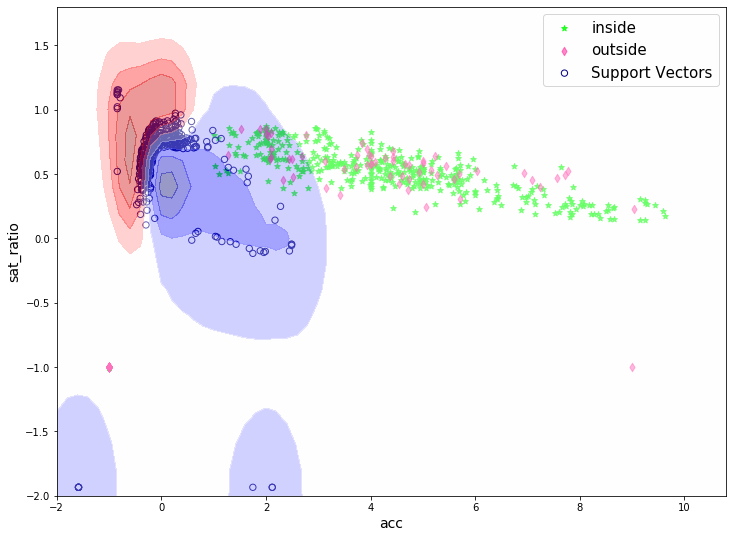

In [44]:
X0,X1 = master_data.iloc[:,2].to_numpy(),master_data.iloc[:,8].to_numpy()
xx,yy = make_meshgrid(X0,X1)
fig,ax = plt.subplots(figsize = (12,9))
fig.patch.set_facecolor('White')
cdict1={0:'lime',1:'deeppink'}
label={0:'inside',1:'outside'}
marker={0:'*',1:'d'}
alpha={0:.8,1:.5}

Y_tar = y_test.tolist()
label1 = [int(target1) for target1 in Y_tar]
for i in np.unique(label1):
    ix1 = np.where(label1==i)
    ax.scatter(X0[ix1],X1[ix1],c=cdict1[i],label=label[i],marker=marker[i],alpha=alpha[i])
    
ax.scatter(clf.support_vectors_[:,0],clf.support_vectors_[:,1],s=40,facecolors='None',
          edgecolors='navy',label='Support Vectors')
plot_contour(ax,classify,xx,yy,cmap='seismic',alpha=0.4)
plt.legend(fontsize=15)

plt.xlabel('acc',fontsize=14)
plt.ylabel('sat_ratio',fontsize=14)



### Random Forest
#### https://medium.com/@garg.mohit851/random-forest-visualization-3f76cdf6456f

In [16]:
# Use Grid Search
clf = RandomForestClassifier()
parameter = [{'n_estimators':[20,50,100],'max_depth':[5,10,50]}]
search = GridSearchCV(clf,parameter,cv=3)
search.fit(X,y)
print (search.best_params_)

{'max_depth': 10, 'n_estimators': 50}


In [17]:
clf = RandomForestClassifier(n_estimators=search.best_params_['n_estimators'],max_depth=search.best_params_['max_depth'])

In [18]:
ave_acc_rf = []
ave_acc_rf_train = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    clf.fit(X_train,y_train)
    ave_acc_rf_train.append(clf.score(X_train,y_train))
    ave_acc_rf.append(clf.score(X_test,y_test))

In [19]:
ave_acc_rf

[0.9984732824427481, 1.0, 0.9954198473282443, 1.0, 1.0]

## Unsupervised
### Do not manully classify, drop N/A

In [58]:
for i in range(len(filename)):
    logger = pd.read_csv(filename[i],delimiter=',')
    logger.drop(['type','name','desc','bearing(deg)'],axis=1,inplace=True)
    logger['new_time'] = pd.to_datetime(logger['date time']).dt.tz_localize('UTC').dt.tz_convert('US/Pacific').dt.tz_localize(None)
    logger.drop('date time',axis=1,inplace=True)
    logger = logger.resample('1T',on='new_time').mean()
    logger['sat_ratio'] = (logger['sat_used'] / logger['sat_inview']) *1.0
    logger = logger.dropna(axis=0,how='any') # drop n/a
    #logger.to_excel(outputname[i])      
    clustering_arr.append(logger)

In [59]:
cluster_data = pd.concat([clustering_arr[0],clustering_arr[1],clustering_arr[2],
                         clustering_arr[3],clustering_arr[4]],axis=0)



Text(0.5, 1.0, 'Oct7-Oct11')

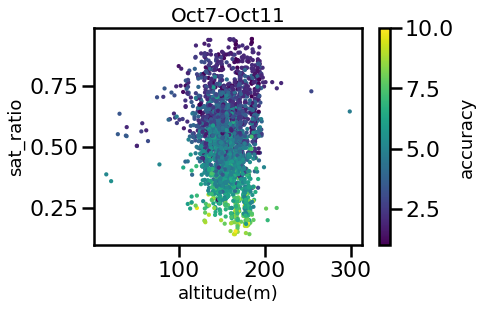

In [198]:
plt.scatter(x=cluster_data['altitude(m)'],y=cluster_data['sat_ratio'],c=cluster_data['accuracy(m)'],cmap='viridis',s=5)
plt.xlabel('altitude(m)',fontsize=18)
plt.ylabel('sat_ratio',fontsize=18)
plt.colorbar().ax.set_ylabel('accuracy', rotation=-270,fontsize=18)
plt.title('Oct7-Oct11',fontsize=20)

In [222]:
cluster_data.shape

(3182, 9)

### PCA on Dataset

In [141]:
features = ['latitude', 'longitude', 'accuracy(m)', 'altitude(m)',
       'geoid_height(m)', 'speed(m/s)', 'sat_used', 'sat_inview', 'sat_ratio']
# Separating out the features
x = cluster_data.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)


In [142]:
pca = PCA(n_components=2)
PC = pca.fit_transform(x)
pDf = pd.DataFrame(data = PC, columns = ['pc1', 'pc2'])


### K Means

In [155]:
clu_data = cluster_data[['accuracy(m)','sat_ratio']]

### https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

In [211]:
plot_kwds = {'alpha' : 0.4, 's' : 25, 'linewidths':0}
sns.set_context('poster')
sns.set_color_codes()

Text(0.5, 1.0, 'PCA data & drop N/A')

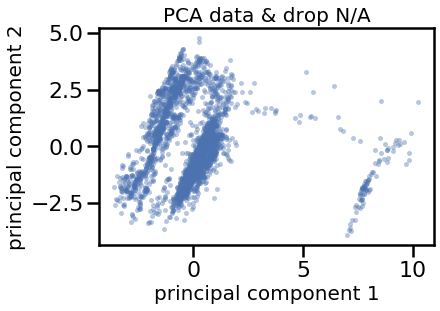

In [212]:
plt.scatter(pDf.iloc[:,0], pDf.iloc[:,1], c='b', **plot_kwds)
plt.xlabel('principal component 1',fontsize=20)
plt.ylabel('principal component 2',fontsize=20)
plt.title('PCA data & drop N/A',fontsize=20)

Text(0.5, 1.0, 'raw data & drop N/A')

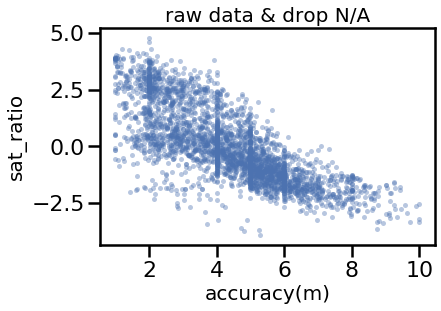

In [213]:
plt.scatter(clu_data.iloc[:,0], pDf.iloc[:,1], c='b', **plot_kwds)
plt.xlabel('accuracy(m)',fontsize=20)
plt.ylabel('sat_ratio',fontsize=20)
plt.title('raw data & drop N/A',fontsize=20)

In [214]:
def plot_clusters(data, algorithm, args, kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.iloc[:,0], data.iloc[:,1], c=colors, **plot_kwds)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.xlabel('principal component 1',fontsize=20)
    plt.ylabel('principal component 2',fontsize=20)

In [220]:
def plot_clusters2(data, algorithm, args, kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette("husl", np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.iloc[:,2], data.iloc[:,8], c=colors,**plot_kwds)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.xlabel('accuracy',fontsize=20)
    plt.ylabel('sat_ratio',fontsize=20)
    plt.legend()
    

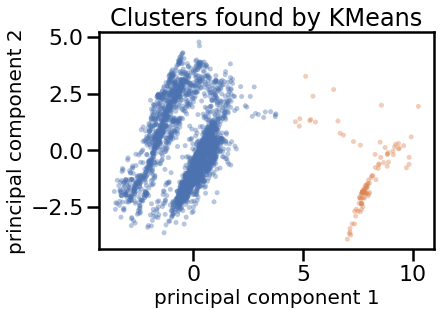

In [216]:
plot_clusters(pDf, cluster.KMeans, (), {'n_clusters':2})

No handles with labels found to put in legend.


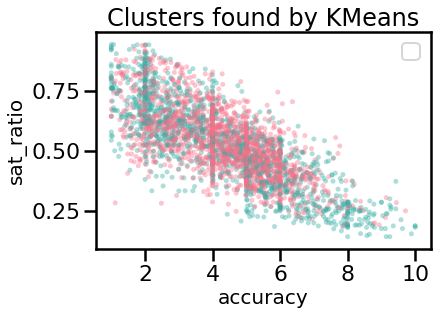

In [221]:
plot_clusters2(cluster_data, cluster.KMeans, (), {'n_clusters':2})

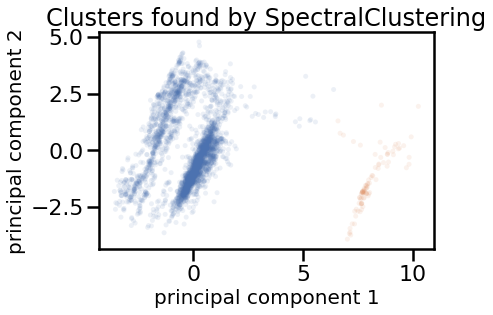

In [188]:
plot_clusters(pDf, cluster.SpectralClustering, (), {'n_clusters':2})

In [219]:
plot_clusters2(cluster_data, cluster.SpectralClustering, (), {'n_clusters':2})

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 